In [1]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from WiSARD import WiSARD
import numpy as np
import pandas as pd
import math
import sys
import random
import matplotlib.pyplot as plt
import itertools
from Utils import thermometer,one_hot

pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
qtd_splits = 10
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from time import time
from collections import defaultdict

import itertools
#import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#model = KeyedVectors.load_word2vec_format('../glove.6B.50d.word2vec.txt')

In [3]:
df = {
    "cooking": pd.read_csv('../dataset/processed/cooking.csv'),
    "crypto": pd.read_csv('../dataset/processed/crypto.csv'),
    "robotics": pd.read_csv('../dataset/processed/robotics.csv'),
    "biology": pd.read_csv('../dataset/processed/biology.csv'),
    "travel": pd.read_csv('../dataset/processed/travel.csv'),
    "diy": pd.read_csv('../dataset/processed/diy.csv'),
    #"physics": pd.read_csv('physics.csv'),
}

X = []
y = []

for file in df:
    for i in range(df[file].shape[0]):
        doc = ''
        if type(df[file].iloc[i]['title']) is str:
            doc += df[file].iloc[i]['title'] + ' '
        if type(df[file].iloc[i]['content']) is str:
            doc += df[file].iloc[i]['content'] + ' '
            X.append(doc)
            y.append(file)
    #f = pd.DataFrame(X)
    #f.to_csv("../dataset/word2vec/" + file + ".csv", index=False)

In [4]:
l_enc = LabelEncoder()
y_enc = l_enc.fit_transform(y)
print('Encoded labels: ', list([(i, l_enc.classes_[i]) for i in range(0, len(l_enc.classes_))]))

Encoded labels:  [(0, 'biology'), (1, 'cooking'), (2, 'crypto'), (3, 'diy'), (4, 'robotics'), (5, 'travel')]


## Functions 

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
      
    plt.figure(figsize=(12,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title(title + " normalized confusion matrix")
    else:
        plt.title(title + ' confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    

def benchmark(clf, X_train, y_train, X_test, y_test):

    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    cm = confusion_matrix(y_test, pred)  
    
    clf_descr = str(clf).split('(')[0]
    print("Done with " + clf_descr)
    print('_' * 80)
    
    return clf_descr, score, train_time, test_time, cm

def show_results(cf, name):
    print(name)
    print(cf)
    print('\n')
    print('Mean accuracy: ' + str((np.array(cf['score'])).mean()) + ' +/- ' + str((np.array(cf['score'])).std()))
    print('Mean train time: ' + str((np.array(cf['train_time'])).mean()) + ' +/- ' + str((np.array(cf['train_time'])).std()))
    print('Mean test time: ' + str((np.array(cf['test_time'])).mean()) + ' +/- ' + str((np.array(cf['test_time'])).std()))
    print('Mean confusion matrix:')
    
    t = [np.matrix(x) for x in cf['confusion_matrix']]
    su = np.matrix(t[0])
    for i in range(1,len(t)):
        su += t[i]
    plot_confusion_matrix(np.squeeze(np.asarray(su)), l_enc.classes_, title=name, normalize=True)
    
    print('_' * 80)

In [6]:
sv = CountVectorizer(binary=True, max_df=0.7, min_df=300)
X_bow = sv.fit_transform(X)

In [7]:
len(sv.vocabulary_)

2192

## Kfold

In [8]:
X_train = np.array(X_bow.toarray())
y_train = np.array(y_enc)

kf = StratifiedKFold(n_splits=10)

#results = defaultdict(list)
resultsGaussianNB = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsBernoulliNB = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsRandomForest = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsSVM = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsWisardThermometer = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsWisardOneHot = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }


for train, test in kf.split(X_train, y_train):
    clfr = benchmark(GaussianNB(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsGaussianNB['score'].append(clfr[1])
    resultsGaussianNB['train_time'].append(clfr[2])
    resultsGaussianNB['test_time'].append(clfr[3])
    resultsGaussianNB['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(BernoulliNB(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsBernoulliNB['score'].append(clfr[1])
    resultsBernoulliNB['train_time'].append(clfr[2])
    resultsBernoulliNB['test_time'].append(clfr[3])
    resultsBernoulliNB['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(RandomForestClassifier(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsRandomForest['score'].append(clfr[1])
    resultsRandomForest['train_time'].append(clfr[2])
    resultsRandomForest['test_time'].append(clfr[3])
    resultsRandomForest['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(svm.LinearSVC(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsSVM['score'].append(clfr[1])
    resultsSVM['train_time'].append(clfr[2])
    resultsSVM['test_time'].append(clfr[3])
    resultsSVM['confusion_matrix'].append(clfr[4])
    


Training: 
GaussianNB(priors=None)
train time: 41.490s
test time:  6.455s
accuracy:   0.819
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 3.826s
test time:  1.936s
accuracy:   0.832
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 4.492s
test time:  1.886s
accuracy:   0.841
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 4.153s
test time:  1.939s
accuracy:   0.844
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 4.236s
test time:  1.951s
accuracy:   0.843
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)

All results


Naïve-Bayes Gaussian
{'score': [0.81912204091013563, 0.83222247759135826, 0.84082289392023901, 0.84392598551890585, 0.84344827586206894, 0.84632183908045977, 0.8421657661800207, 0.846649040119554, 0.85042538514601063, 0.84107635694572214], 'train_time': [41.49038290977478, 3.825603485107422, 4.492288827896118, 4.153019905090332, 4.236449241638184, 4.1227335929870605, 4.641392230987549, 4.21339750289917, 4.362895727157593, 4.17960262298584], 'test_time': [6.454932689666748, 1.9361872673034668, 1.8858497142791748, 1.9385647773742676, 1.9512932300567627, 2.0626018047332764, 1.9363760948181152, 2.001865863800049, 2.0204362869262695, 1.9012575149536133], 'confusion_matrix': [array([[ 879,   47,  137,    9,  240,    8],
       [  17, 1349,   60,   14,   93,    8],
       [   2,    0, 1035,    0,    7,    0],
       [  31,   98,   26, 1974,  446,   17],
       [   7,    0,   15,    8,  245,    2],
       [  10,   32,   42,   21,  177, 1646]]), array([[ 806,   60,  155,    8,  27

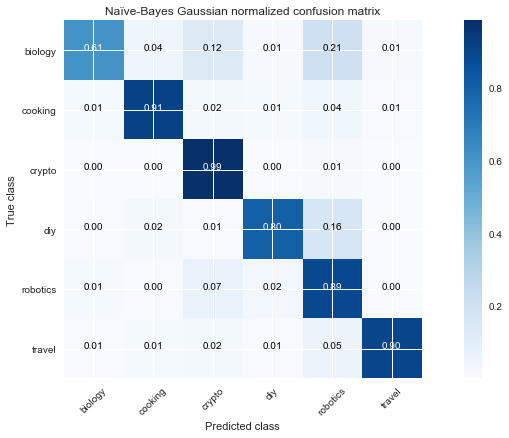

________________________________________________________________________________
Naïve-Bayes Bernoulli
{'score': [0.90634336934038151, 0.92495977936106644, 0.9289736811860706, 0.92483622572118152, 0.92620689655172417, 0.93229885057471262, 0.92573859064260255, 0.92953213012989999, 0.92710968038629571, 0.9241030358785649], 'train_time': [15448.678599357605, 131.63854312896729, 88.65951776504517, 53.15441131591797, 7.4016828536987305, 4.650045871734619, 4.623024940490723, 4.581945896148682, 4.17217493057251, 4.111741065979004], 'test_time': [29.0929114818573, 29.181576013565063, 7.603011131286621, 6.446759462356567, 0.5038294792175293, 0.5648703575134277, 0.57037353515625, 0.5873847007751465, 0.48381829261779785, 0.5488591194152832], 'confusion_matrix': [array([[1255,   25,    3,    9,   23,    5],
       [  99, 1419,    1,   14,    3,    5],
       [  66,    1,  970,    0,    3,    4],
       [ 161,  137,    1, 2236,   37,   20],
       [  37,    1,    4,    5,  228,    2],
       [  92,

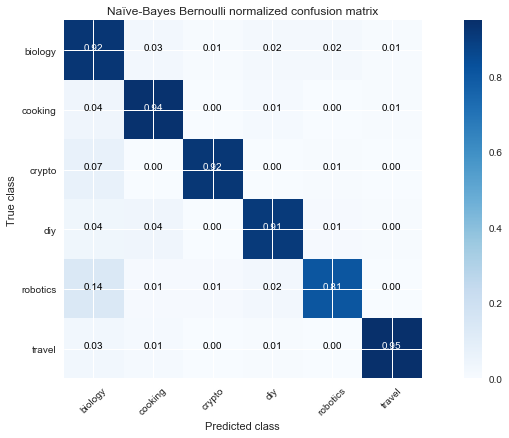

________________________________________________________________________________
Random Forest
{'score': [0.89841415766490462, 0.90599862100666517, 0.90771175726927944, 0.89989656361337778, 0.91034482758620694, 0.90988505747126436, 0.90769053914243014, 0.91182894585584551, 0.9049206714187169, 0.90524379024839008], 'train_time': [64.09691762924194, 52.08492660522461, 50.25675415992737, 48.47782492637634, 50.574098110198975, 53.92831087112427, 53.51766514778137, 56.03743362426758, 46.45767617225647, 47.012781620025635], 'test_time': [0.5354297161102295, 0.21714282035827637, 0.27718091011047363, 0.2317969799041748, 0.2561678886413574, 0.20963764190673828, 0.24515986442565918, 0.26267433166503906, 0.2616727352142334, 0.1627817153930664], 'confusion_matrix': [array([[1193,   51,   14,   39,    3,   20],
       [  81, 1364,    6,   70,    0,   20],
       [  50,    7,  968,   12,    1,    6],
       [  80,   93,   10, 2376,    3,   30],
       [  20,   11,   12,   35,  187,   12],
       [  

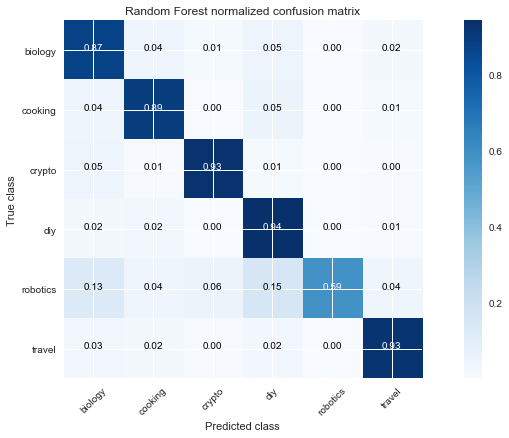

________________________________________________________________________________
SVM
{'score': [0.94748333716387034, 0.95518271661686971, 0.95368348465693598, 0.9508102516952075, 0.95459770114942533, 0.95931034482758626, 0.95171858834348777, 0.95344292447407752, 0.95481719935617382, 0.9508969641214351], 'train_time': [17.012939929962158, 15.143954038619995, 14.865283966064453, 14.306628227233887, 14.252671480178833, 14.566076517105103, 14.96689224243164, 14.376156091690063, 14.452215909957886, 14.684962511062622], 'test_time': [0.23830246925354004, 0.12240123748779297, 0.11589360237121582, 0.11590909957885742, 0.1159067153930664, 0.12241291999816895, 0.11589503288269043, 0.11589336395263672, 0.11589717864990234, 0.13152217864990234], 'confusion_matrix': [array([[1240,   27,   12,   13,    7,   21],
       [  41, 1449,    7,   33,    1,   10],
       [  12,    4, 1019,    0,    4,    5],
       [  44,   48,    6, 2459,    9,   26],
       [  16,    2,    7,   12,  234,    6],
       [  

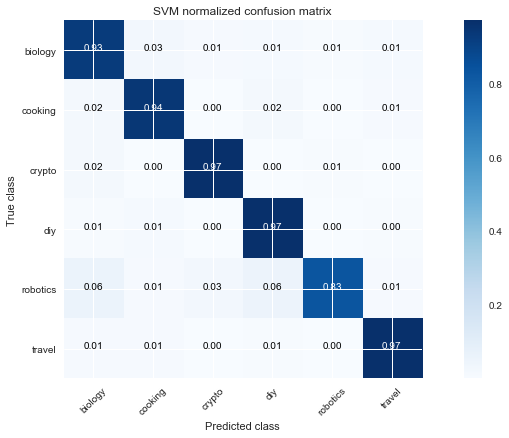

________________________________________________________________________________


In [9]:
print('All results')
print('\n')

show_results(resultsGaussianNB, 'Naïve-Bayes Gaussian')
show_results(resultsBernoulliNB, 'Naïve-Bayes Bernoulli')
show_results(resultsRandomForest, 'Random Forest')
show_results(resultsSVM, 'SVM')

In [ ]:
X_train = np.array(X_bow.toarray())
y_train = np.array(y_enc)

kf = StratifiedKFold(n_splits=10)

resultsWisardOneHot = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }

#X_train = np.array(X_onehot)
for train, test in kf.split(X_train, y_train):
    clfr = benchmark(WiSARD(4, seed=random.randint(0, 2**32-1), ignore_zero_addr=True), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsWisardOneHot['score'].append(clfr[1])
    resultsWisardOneHot['train_time'].append(clfr[2])
    resultsWisardOneHot['test_time'].append(clfr[3])
    resultsWisardOneHot['confusion_matrix'].append(clfr[4])

Training: 
train time: 1232.230s
test time:  843.665s
accuracy:   0.767
Done with <WiSARD.WiSARD object at 0x000001EB976581D0>
________________________________________________________________________________
Training: 
train time: 1215.281s
test time:  814.396s
accuracy:   0.765
Done with <WiSARD.WiSARD object at 0x000001EB976581D0>
________________________________________________________________________________
Training: 
train time: 1219.719s
test time:  877.120s
accuracy:   0.767
Done with <WiSARD.WiSARD object at 0x000001EB976581D0>
________________________________________________________________________________
Training: 
train time: 1109.777s
test time:  791.800s
accuracy:   0.761
Done with <WiSARD.WiSARD object at 0x000001EB976581D0>
________________________________________________________________________________
Training: 
train time: 1115.635s
test time:  797.868s
accuracy:   0.762
Done with <WiSARD.WiSARD object at 0x000001EB976581D0>
_________________________________________

In [ ]:
#show_results(resultsWisardThermometer, 'WiSARD with Thermometer')
show_results(resultsWisardOneHot, 'WiSARD with One Hot')